June: Creating flux containers/planes and looking at scaling factors.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

# Load Bathymetry and Mesh

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177_80/Run01/'
with nc.Dataset(os.path.join(path, 'mesh_mask.nc'), 'r') as nbl:
    gdepw_1d = nbl.variables['gdepw_1d'][0,...]
    gdepw_0 = nbl.variables['gdepw_0'][0,...]
    gdepu = nbl.variables['gdepu'][0,...]
    gdepv = nbl.variables['gdepv'][0,...]
    e3t_1d = nbl.variables['e3t_1d'][0,...]
    e3t_0 = nbl.variables['e3t_0'][0,...]
    e3w_1d = nbl.variables['e3w_1d'][0,...]
    e3w_0 = nbl.variables['e3w_0'][0,...]
    e3u_0 = nbl.variables['e3u_0'][0,...]
    e3v_0 = nbl.variables['e3v_0'][0,...]
    e1v = nbl.variables['e1v'][0,...]
    e1u = nbl.variables['e1u'][0,...]
    e2u = nbl.variables['e2u'][0,...]
    e1t = nbl.variables['e1t'][0,...]
    umask = nbl.variables['umask'][0,...]
    vmask = nbl.variables['umask'][0,...]
    tmask = nbl.variables['tmask'][0,...]
    mbathy = nbl.variables['mbathy'][0,...]

In [3]:
def get_shelfbreak_plane(bathy, gdepw_1d):
    '''Finds the y-index of the point at which the shelf break
    is located (which is at approximately 80 m but depends on 
    the resolution). It also extracts the cross section of the 
    bathymetry at the shelf break.
    -----------------------------
    bathy (y,x)
    gdepw_1d (z,)
    bathy_plane (x,)
    '''
    
    depth_shelf_approx = 80
    ind_shelf = np.argmin(np.abs(gdepw_1d - depth_shelf_approx))
    depth_shelf = gdepw_1d[ind_shelf]
    ind_plane = np.argmin(np.abs(bathy[:,0] - depth_shelf))
    bathy_plane = bathy[ind_plane,:]
    
    return ind_plane, bathy_plane, ind_shelf, depth_shelf

In [5]:
ind_plane, bathy_plane, ind_shelf, depth_shelf = get_shelfbreak_plane(bathy, gdepw_1d)
ind_plane, ind_shelf, depth_shelf

(61, 9, 78.750000000000057)

In [4]:
def define_horizontal_fluxplanes(bathy, gdepw_1d, bathy_plane, area):
    ''' Finds the depth-indices for the horizontal flux planes
    (i.e. at the shelf, at the bottom of the canyon, and mid-way
    where the area of the canyon above equals the area below it).
    -----------------------------
    bathy (y,x)
    gdepw_1d (z,)
    bathy_plane (x,)
    area (z, x)
    '''
    
    # depth closest to the shelf depth (~80 m)
    depth_shelf_approx = 80
    ind_shelf = np.argmin(np.abs(gdepw_1d - depth_shelf_approx))
    depth_shelf = gdepw_1d[ind_shelf]
    
    # ind and depth closest to the canyon bottom
    depth_bottom_approx = bathy_plane.max()
    ind_bottom = np.argmin(np.abs(gdepw_1d - depth_bottom_approx))
    depth_bottom = gdepw_1d[ind_bottom]

    # calculate the area of all cells along a single row
    area_all = np.zeros(area.shape[0])
    for depth_ind in range(area.shape[0]):
        area_row =area[depth_ind,:].sum()
        area_all[depth_ind] = area_row
    
    # narrow down the areas of rows to only those inside canyon
    area_canyon = area_all[ind_shelf:ind_bottom]
    area_canyon_inds = np.arange(ind_shelf,ind_bottom)

    # find row (or depth) at which we have half the area in canyon
    total_area_canyon = np.sum(area_canyon)
    half_area_canyon = total_area_canyon / 2
    cumsum_area_canyon = np.cumsum(area_canyon)
    half_area_canyon_ind = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()
    ind_half = area_canyon_inds[half_area_canyon_ind]
    depth_half = gdepw_1d[ind_half]

    sum_area_plane = np.sum(area_all)
    sum_area_over_break = np.sum(area_all[:ind_shelf])
    sum_area_top_half = np.sum(area_all[ind_shelf:ind_half+1])
    sum_area_bot_half = np.sum(area_all[ind_half+1:])
    
    return ind_shelf, depth_shelf, ind_bottom, depth_bottom, ind_half, depth_half

In [6]:
# ind and depth closest to the canyon bottom
depth_bottom_approx = bathy_plane.max()
ind_bottom = np.argmin(np.abs(gdepw_1d - depth_bottom_approx))
depth_bottom = gdepw_1d[ind_bottom]

depth_bottom

498.75567162859738

In [5]:
def define_vertical_fluxplanes(bathy_plane):
    ''' Finds the x-indices, which are points in the along-shore
    direction, for the vertical flux planes (i.e. at the rims,
    on the shelf away from the rims, and at the canyon axis). 
    -----------------------------
    bathy_plane (x,)
    '''
    
    # depth closest to the bottom of the canyon
    depth_bottom_approx = bathy_plane.max()
    
    # canyon axis
    ind_axis = np.where(bathy_plane == depth_bottom_approx)[0][0]
    
    # finding the potential rim points
    slope = abs(np.diff(bathy_plane))
    ind_rimL0 = np.where(slope > 0.01)[0][0]
    ind_rimR0 = np.where(slope > 0.01)[0][-1]
    
    # index of the actual rim points
    width_shelf = max(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
    ind_rimL = ind_axis - width_shelf
    ind_rimR = ind_axis + width_shelf
    
    # adjacent containers with the same width
    ind_shfL = ind_rimL - width_shelf
    ind_shfR = ind_rimR + width_shelf
    
    return ind_axis, ind_rimL, ind_rimR, ind_shfL, ind_shfR

In [6]:
def calculate_area_allcells(e1v, e3v_0, e2u, e3u_0, ind_plane, tmask):
    '''Calculates the areas of all wet and partial wet cells
    in the i- and j-component for fluxes using u and v.
    -----------------------------
    e1v (y, x)
    e3v_0 (z, y, x)
    e2u (y, x)
    e3u_0(z, y, x)
    tmask (z, y, x)
    area_j (z, x)
    area_i (z, x)
    tmask_plane (z, x)
    '''
    
    tmask_plane = tmask[:,ind_plane,:]

    cell_x_j = e1v[ind_plane, :]
    cell_y_j = e3v_0[:,ind_plane,:]
    area_j = tmask_plane * cell_x_j * cell_y_j

    cell_x_i = e2u[ind_plane, :]
    cell_y_i = e3u_0[:,ind_plane,:]
    area_i = tmask_plane * cell_x_i * cell_y_i
    
    return area_j, area_i, tmask_plane

In [7]:
def calculate_flux(vel_plane, vel_mask, ind_plane, area):
    '''Calculates the flux through all cells along the shelf break
    cross-section for one instance in time.
    -----------------------------
    vel_plane (t, z, x)
    vel_mask(z, y, x)
    area (z, x)
    Q (z, x)
    vel_masked (z, x)
    '''
    
    vel_plane = vel_plane[time_ind, :, :]
    vel_mask_plane = 1 - vel_mask[:, ind_plane, :]
    vel_masked = np.ma.array(vel_plane, mask=vel_mask_plane)
    Q = vel_masked * area
    return Q, vel_masked

# Cross-Section at Shelf Break

### Function

In [8]:
ind_plane, bathy_plane, ind_shelf, depth_shelf = get_shelfbreak_plane(bathy, gdepw_1d)

print(bathy.shape, gdepw_1d.shape)
print(ind_plane.shape, bathy_plane.shape, ind_shelf.shape, depth_shelf.shape)

(177, 237) (80,)
() (237,) () ()


### Plot

<a list of 1 text.Text objects>

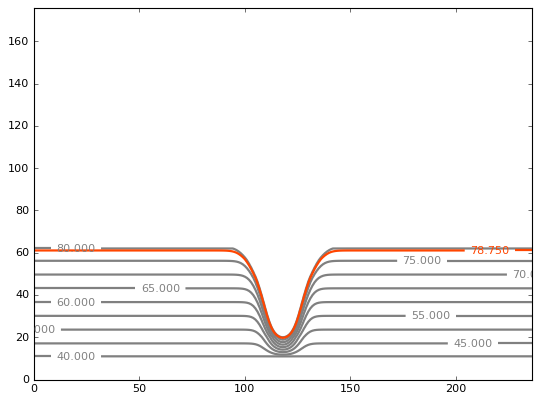

In [9]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*6, 6))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=2)
c1 = ax.contour(bathy[:,:], levels = [depth_shelf], colors='orangered', linewidths=2)
ax.clabel(c, inline=1, fontsize=10)
ax.clabel(c1, inline=1, fontsize=10)

# Areas of Cells for Flux

### Function

In [10]:
area_j, area_i, tmask_plane = calculate_area_allcells(e1v, e3v_0, e2u, e3u_0, ind_plane, tmask)

print(e1v.shape, e3v_0.shape, e2u.shape, e3u_0.shape, ind_plane.shape, tmask.shape)
print(area_j.shape, area_i.shape, tmask_plane.shape)

(177, 237) (80, 177, 237) (177, 237) (80, 177, 237) () (80, 177, 237)
(80, 237) (80, 237) (80, 237)


### Plots

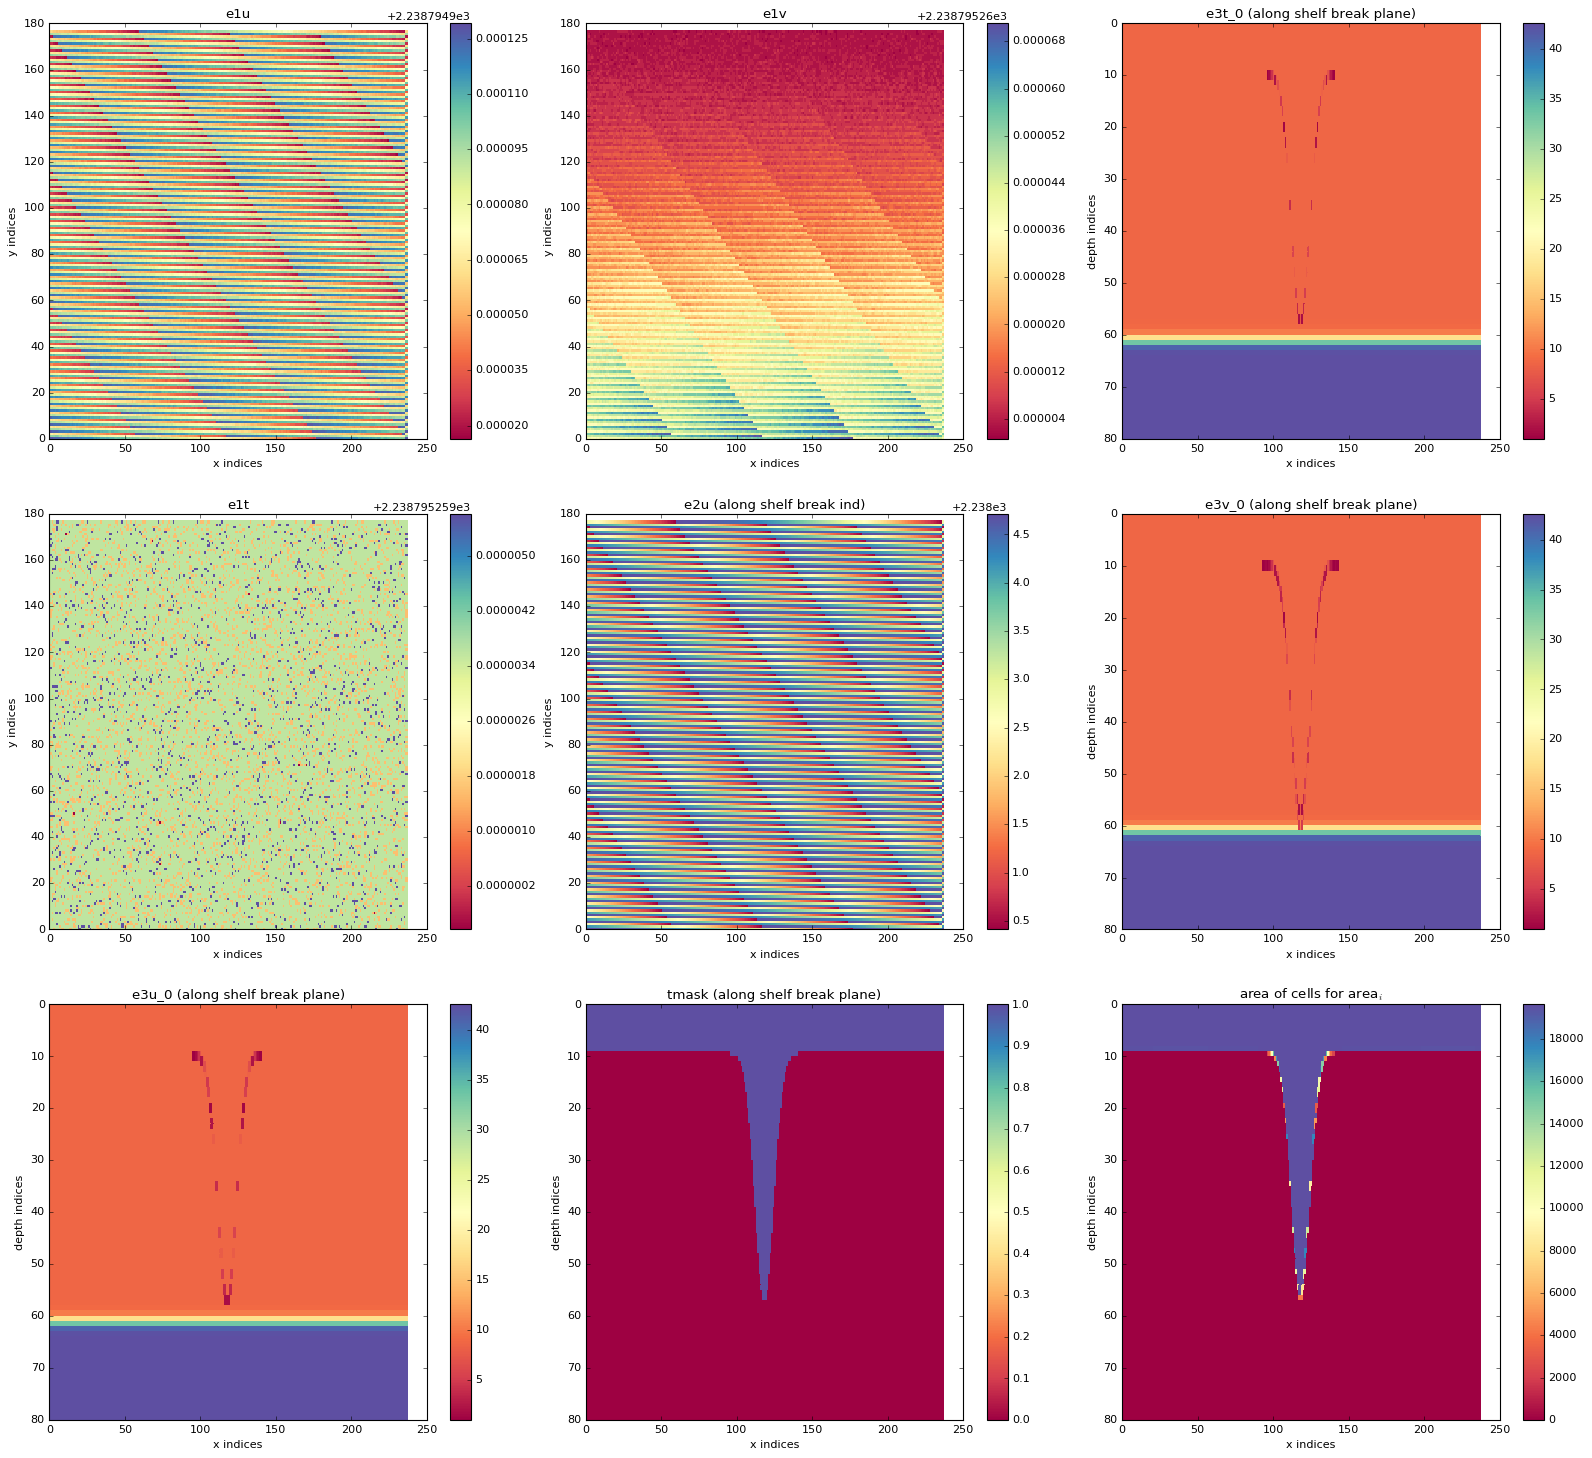

In [11]:
fig, ([ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9]) = plt.subplots(3,3, figsize=(20,18))
plt.tight_layout(h_pad=5, w_pad=3)
ax3.set_title('e3t_0 (along shelf break plane)')
ax3.set_ylabel('depth indices'); ax3.set_xlabel('x indices')
ax1.set_title('e1u')
ax1.set_ylabel('y indices'); ax1.set_xlabel('x indices')
ax2.set_title('e1v')
ax2.set_ylabel('y indices'); ax2.set_xlabel('x indices')
ax8.set_title('tmask (along shelf break plane)')
ax8.set_ylabel('depth indices'); ax8.set_xlabel('x indices')
ax4.set_title('e1t')
ax4.set_ylabel('y indices'); ax4.set_xlabel('x indices')
ax5.set_title('e2u (along shelf break ind)')
ax5.set_ylabel('y indices'); ax5.set_xlabel('x indices')
ax7.set_title('e3u_0 (along shelf break plane)')
ax7.set_ylabel('depth indices'); ax7.set_xlabel('x indices')
ax6.set_title('e3v_0 (along shelf break plane)')
ax6.set_ylabel('depth indices'); ax6.set_xlabel('x indices')
ax9.set_title('area of cells for area$_i$')
ax9.set_ylabel('depth indices'); ax9.set_xlabel('x indices')

p = ax1.pcolor(e1u[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax1)

p = ax2.pcolor(e1v[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax2)

p3 = ax3.pcolor(e3t_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p3, ax=ax3)
ax3.invert_yaxis()

p = ax4.pcolor(e1t[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax4)

p = ax5.pcolor(e2u, cmap=cm.Spectral)
fig.colorbar(p, ax=ax5)

p = ax6.pcolor(e3v_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax6)
ax6.invert_yaxis()

p = ax7.pcolor(e3u_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax7)
ax7.invert_yaxis()

p = ax8.pcolor(tmask_plane, cmap=cm.Spectral)
fig.colorbar(p, ax=ax8)
ax8.invert_yaxis()

p = ax9.pcolor(area_i, cmap=cm.Spectral)
fig.colorbar(p, ax=ax9)
ax9.invert_yaxis()

# Planes along Cross-Section for Flux

### Functions

In [12]:
ind_axis, ind_rimL, ind_rimR, ind_shfL, ind_shfR = define_vertical_fluxplanes(bathy_plane)

print(bathy_plane.shape)
print(ind_axis.shape, ind_rimL.shape, ind_rimR.shape, ind_shfL.shape, ind_shfR.shape)

(237,)
() () () () ()


In [13]:
area = area_i
ind_shelf, depth_shelf, ind_bottom, depth_bottom, ind_half, depth_half = define_horizontal_fluxplanes(bathy, gdepw_1d, bathy_plane, area)


print(bathy.shape, gdepw_1d.shape, bathy_plane.shape, area.shape)
print(ind_shelf.shape, depth_shelf.shape, ind_bottom.shape, depth_bottom.shape, ind_half.shape, depth_half.shape)

(177, 237) (80,) (237,) (80, 237)
() () () () () ()


### Plot

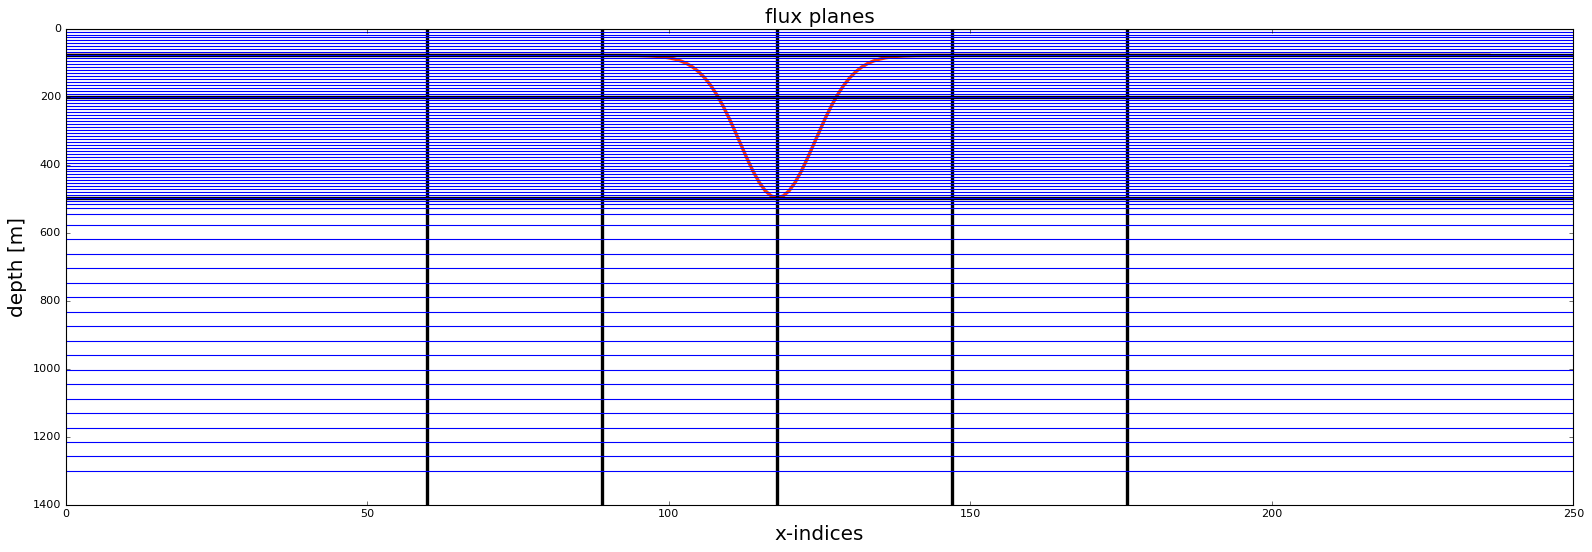

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,7))

ax.plot(bathy_plane, lw=3, c='orangered')
ax.invert_yaxis()
lw = 3; c='k'
ax.axhline(depth_shelf, c=c, lw=lw)
ax.axhline(depth_bottom, c=c, lw=lw)
ax.axhline(depth_half, c=c, lw=lw)
ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)
for gdepw in zip(gdepw_1d):
    ax.axhline(gdepw, c='b', label = 'gdepw')
ax.set_title('flux planes', fontsize=18)
ax.set_ylabel('depth [m]', fontsize=18)
ax.set_xlabel('x-indices', fontsize=18)
    
plt.tight_layout(h_pad=5, w_pad=3)

# Flux Basic
# $Q_j = v \times e1v \times e3v = v \times A_j$

# $Q_i = u \times e2u \times e3u = u \times A_i$

### Functions

In [15]:
with nc.Dataset(os.path.join(path, 'GYRE_1h_20170101_20170120_grid_U.nc'), 'r') as nbl:
    U_plane = nbl.variables['vozocrtx'][:, :, ind_plane, :]
    
with nc.Dataset(os.path.join(path, 'GYRE_1h_20170101_20170120_grid_V.nc'), 'r') as nbl:
    V_plane = nbl.variables['vomecrty'][:, :, ind_plane, :]

In [16]:
time_ind = 160
Qi, U_masked = calculate_flux(U_plane, umask, ind_plane, area_i)
Qj, V_masked = calculate_flux(V_plane, vmask, ind_plane, area_j)

print(U_plane.shape, umask.shape, ind_plane.shape, area_i.shape)
print(Qi.shape, U_masked.shape)

(480, 80, 237) (80, 177, 237) () (80, 237)
(80, 237) (80, 237)


### Plots

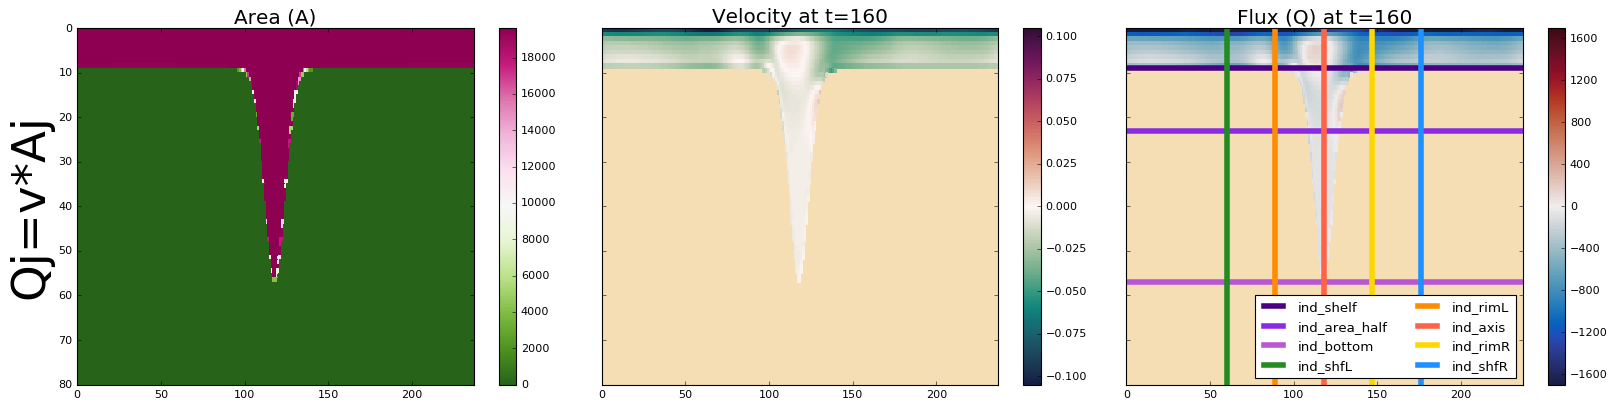

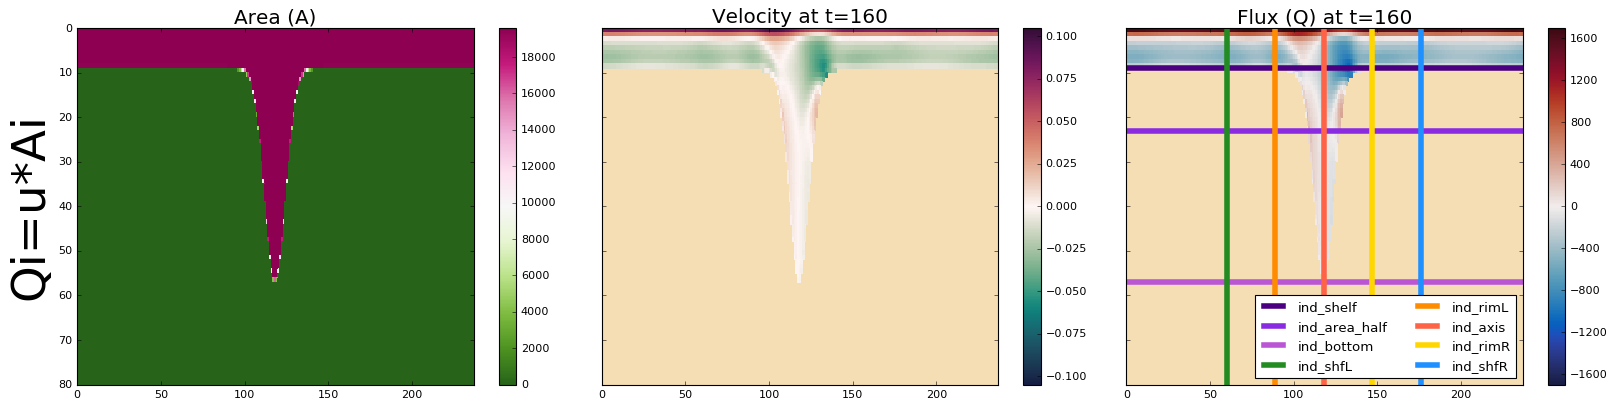

In [17]:
for plot_area, plot_vel, plot_Q, ttl in zip([area_i, area_j], [U_masked, V_masked], [Qi, Qj], ['Qj=v*Aj', 'Qi=u*Ai']):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5), sharey=True, sharex=True)
    plt.tight_layout(h_pad=5, w_pad=1)

    p = ax1.pcolor(plot_area, cmap=cm.PiYG_r)
    fig.colorbar(p, ax=ax1)
    ax1.set_title('Area (A)', fontsize=18)

    p = ax2.pcolor(plot_vel, vmin=-0.105, vmax=0.105, cmap=cmo.cm.curl)
    ax2.set_axis_bgcolor('wheat')
    fig.colorbar(p, ax=ax2)
    ax2.set_title('Velocity at t=' + str(time_ind), fontsize=18)

    lw=5
    ax3.axhline(ind_shelf, c='indigo', lw=lw, label='ind_shelf')
    ax3.axhline(ind_half, c='blueviolet', lw=lw, label='ind_area_half')
    ax3.axhline(ind_bottom, c='mediumorchid', lw=lw, label='ind_bottom')

    ax3.axvline(ind_shfL, c='forestgreen', lw=lw, label='ind_shfL')
    ax3.axvline(ind_rimL, c='darkorange', lw=lw, label='ind_rimL')
    ax3.axvline(ind_axis, c='tomato', lw=lw, label='ind_axis')
    ax3.axvline(ind_rimR, c='gold', lw=lw, label='ind_rimR')
    ax3.axvline(ind_shfR, c='dodgerblue', lw=lw, label='ind_shfR')

    p = ax3.pcolor(plot_Q, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
    fig.colorbar(p, ax=ax3)
    ax3.set_axis_bgcolor('wheat')
    ax3.set_xlim([0, Qi.shape[1]])
    ax3.invert_yaxis()
    ax3.legend(loc=4, ncol=2)
    ax3.set_title('Flux (Q) at t=' + str(time_ind), fontsize=18)
    ax1.set_ylabel(ttl, fontsize=42)

# Areas of Sections

In [18]:
def extract_plane_sections(variable):
    var_over_break_shfL = variable[:ind_shelf, ind_shfL:ind_rimL]
    var_over_break_rimL = variable[:ind_shelf, ind_rimL:ind_axis]
    var_over_break_rimR = variable[:ind_shelf, ind_axis:ind_rimR]
    var_over_break_shfR = variable[:ind_shelf, ind_rimR:ind_shfR]
    
    var_topL = variable[ind_shelf:ind_area_half+1, ind_rimL:ind_axis]
    var_topR = variable[ind_shelf:ind_area_half+1, ind_axis:ind_rimR]
    
    var_botL = variable[ind_area_half+1:, ind_rimL:ind_axis]
    var_botR = variable[ind_area_half+1:, ind_axis:ind_rimR]
    
    return var_over_break_shfL, var_over_break_rimL, var_over_break_rimR, var_over_break_shfR,\
            var_topL, var_topR, var_botL, var_botR
 

In [19]:
   
def total_variable_plane_sections(var_over_break_shfL, var_over_break_rimL, var_over_break_rimR, var_over_break_shfR, var_topL, var_topR, var_botL, var_botR):
    tot_var_over_break_shfL = np.sum(var_over_break_shfL)
    tot_var_over_break_rimL = np.sum(var_over_break_rimL)
    tot_var_over_break_rimR = np.sum(var_over_break_rimR)
    tot_var_over_break_shfR = np.sum(var_over_break_shfR)

    tot_var_topL = np.sum(var_topL)
    tot_var_topR = np.sum(var_topR)
    tot_var_botL = np.sum(var_botL)
    tot_var_botR = np.sum(var_botR)
    
    return tot_var_over_break_shfL, tot_var_over_break_rimL, tot_var_over_break_rimR, tot_var_over_break_shfR,\
            tot_var_topL, tot_var_topR, tot_var_botL, tot_var_botR

# Flux of Section

In [ ]:
# y index of shelf break 
#cells_plane = vmask[ind_shelf, ind_plane, :]
#cells_plane_W = np.count_nonzero(cells_plane)
#cells_plane_D = vmask.shape[-1] - cells_plane_W
#while cells_plane_D > 4:
#    ind_plane += 1
#    cells_plane = vmask[ind_shelf, ind_plane, :]
#    cells_plane_W = np.count_nonzero(cells_plane)
#    cells_plane_D = vmask.shape[-1] - cells_plane_W

#print(ind_plane)